## basics

## RMSNorm

- Pre-normalization Using RMSNorm 
    - root mean square norm

        $$ \begin{align} \begin{split} & \bar{a}_i = \frac{a_i}{\text{RMS}(\mathbf{a})} \odot g_i, \quad \text{where}~~ \text{RMS}(\mathbf{a}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} a_i^2}. \end{split}\nonumber \end{align} $$

    - 我们自然地可以得到一个结论就是，经过 rms norm 之后的 $\bar{\mathbf{a}}$ 其 $\ell_2$ norm 为 $\sqrt n$
       
$$
\|\bar{\mathbf{a}}\|_2=\sqrt{\frac{\sum a_i^2}{\frac1n\sum a_i^2}}=\sqrt{n}
$$
       
```
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
```

In [31]:
import numpy as np
import torch
from torch import nn

In [4]:
bs, seq_len, embedding_dim = 20, 5, 10
x = torch.randn(bs, seq_len, embedding_dim)

### layer norm

In [5]:
ln = nn.LayerNorm(embedding_dim)

In [6]:
x_ln = ln(x)

In [14]:
print(x_ln[1, 4, :].mean())
print(x_ln[1, 4, :].std(unbiased=False))

tensor(-2.4587e-08, grad_fn=<MeanBackward0>)
tensor(1.0000, grad_fn=<StdBackward0>)


### RMSNorm

In [16]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [17]:
rms_norm = RMSNorm(embedding_dim)

In [18]:
x_rms = rms_norm(x)

In [23]:
x[0, 0, :]

tensor([-0.0535,  1.1672,  0.9935,  2.2605,  1.7659,  0.6190,  0.8559, -2.4298,
        -0.2863, -0.9913])

In [27]:
torch.sqrt(torch.sum(x[0, 0, :].pow(2)) / embedding_dim)

tensor(1.3662)

In [24]:
torch.norm(x[0, 0, :])

tensor(4.3203)

In [28]:
x[0, 0, :] / torch.sqrt(torch.sum(x[0, 0, :].pow(2)) / embedding_dim)

tensor([-0.0392,  0.8543,  0.7272,  1.6546,  1.2926,  0.4531,  0.6265, -1.7785,
        -0.2096, -0.7256])

In [22]:
x_rms[0, 0, :]

tensor([-0.0392,  0.8543,  0.7272,  1.6546,  1.2926,  0.4531,  0.6265, -1.7785,
        -0.2096, -0.7256], grad_fn=<SliceBackward0>)

In [29]:
torch.norm(x_rms[0, 0, :])

tensor(3.1623, grad_fn=<LinalgVectorNormBackward0>)

In [32]:
np.sqrt(embedding_dim)

3.1622776601683795

## SwiGLU

- Inspiration of using SwiGLU in LLaMA is taken from PaLM.
- 也叫 SiLU (Sigmoid Linear Unit)，

$$
\text{silu}(x)=x\cdot\sigma(x)=x\cdot\frac{1}{1+\exp(-x)}=\frac{x}{1+\exp(-x)}
$$

In [33]:
def sigmoid(x):
    return  1/(1 + np.exp(-x))

def swish(x):
    return x*sigmoid(x)

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

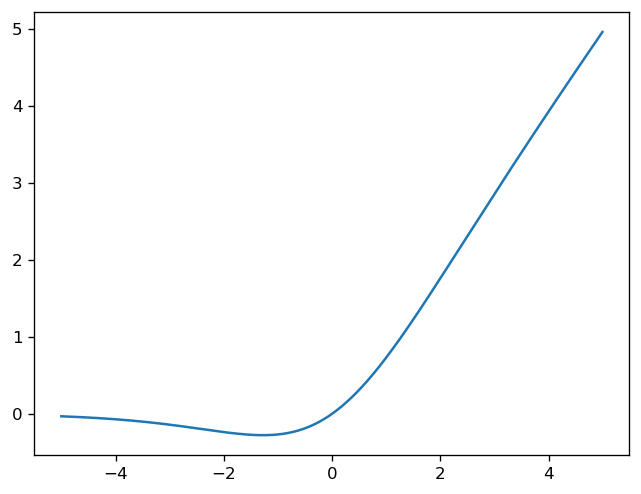

In [36]:
x = np.arange(-5, 5, .01)
plt.plot(x, swish(x))

In [38]:
x = torch.randn(5)
x

tensor([-1.3027,  1.0918, -1.4094,  1.5364,  1.8968])

In [39]:
x/(1+torch.exp(-x))

tensor([-0.2784,  0.8175, -0.2767,  1.2644,  1.6493])

In [40]:
import torch.nn.functional as F

In [41]:
F.silu(x)

tensor([-0.2784,  0.8175, -0.2767,  1.2644,  1.6493])